In [ ]:
from kivy.app import App
from kivy.uix.boxlayout import BoxLayout
from kivy.uix.label import Label
from kivy.uix.button import Button
from kivy.uix.textinput import TextInput
from kivy.uix.scrollview import ScrollView

### Text Representation 

The classifiers and learning algorithms can not directly process the text documents in their original form,as most of them expect numerical feature vectors with a fixed size rather than raw text docs with variable length. Therefore , during the preprocessing step, the texts are converted to a more manageable representation.

One common approach for extracting features from text is to use the bag of words model: a model where for each document, a resume in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored. 

TermFrequency and InverseDocumentFrequency is used for each document.

In [4]:
import pandas as pd
import nltk
df = pd.read_csv('/Users/User/Downloads/UpdatedResumeDataSet.csv', encoding='ISO-8859-1')

# Handle and clean the data if necessary
# For example, remove non-decodable characters or replace them with a placeholder
df['Resume'] = df['Resume'].apply(lambda x: x.encode('ISO-8859-1', 'ignore').decode('ISO-8859-1'))
resume_punc = df["Resume"].copy(deep  = True)
df.head()
#resume_punc
resume_punc = df["Resume"].copy(deep  = True)
df.head()

,Category,Resume,Advice
0,Data Science,Skills * Programming Languages: Python (pandas...,Use action verbs to start your resume bullet p...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Customize your resume for each job application...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Highlight your achievements and quantify them ...
3,Data Science,Skills Ã¢ÂÂ¢ R Ã¢ÂÂ¢ Python Ã¢ÂÂ¢ SAP HANA ...,Proofread your resume to eliminate spelling an...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Keep your resume concise; one to two pages is ...


In [5]:
import string
def rem_punc(s):
    punc = string.punctuation
    return [i for i in s if i not in punc]


In [6]:
import string

# Function to remove punctuation from a string
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# Tokenize and remove punctuation for each row in the DataFrame
for ind, row in df.iterrows():
    text = row["Resume"]
    tokens = text.split()  # Split text into words
    tokens_without_punctuation = [remove_punctuation(word) for word in tokens]
    cleaned_text = " ".join(tokens_without_punctuation)
    df.at[ind, "Resume"] = cleaned_text


In [7]:
import string
from wordcloud import STOPWORDS
def rem_punc(s):
    punc = string.punctuation
    return [i for i in s if i not in punc]

def rem_sw(s):
    sw = set(STOPWORDS)
    return [i for i in s if i not in sw]

def preprocess(eval_res):
    try:
        eval_res = eval(eval_res).decode()
    except:
        pass
    eval_res = eval_res.encode("ASCII","ignore").decode()
    length = len(eval_res)
    eval_res = " ".join(eval_res.split("\n"))
    token = rem_sw(nltk.word_tokenize(eval_res)) #Removing punctaution later since we need punctaution for sentence tokenization
    eval_res = " ".join(token).lower()
    return eval_res

# Cleaning data and adding in ID for category

In [9]:
from io import StringIO
col = ['Category', 'Resume','Advice']
df = df[col]
df = df[pd.notnull(df['Resume'])]
df.columns = ['Category', 'Resume','Advice']
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

df.head()

,Category,Resume,Advice,category_id
0,Data Science,Skills Programming Languages Python pandas nu...,Use action verbs to start your resume bullet p...,0
1,Data Science,Education Details May 2013 to May 2017 BE UITR...,Customize your resume for each job application...,0
2,Data Science,Areas of Interest Deep Learning Control System...,Highlight your achievements and quantify them ...,0
3,Data Science,Skills Ã¢ÂÂ¢ R Ã¢ÂÂ¢ Python Ã¢ÂÂ¢ SAP HANA ...,Proofread your resume to eliminate spelling an...,0
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...,Keep your resume concise; one to two pages is ...,0


### Vectorizing docs

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df.Resume).toarray()
labels = df.category_id
features.shape

(962, 27702)

#### Using chi2 to see correlated items:

In [11]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    #print(feature_names)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    #trigrams = [v for v in feature_names if len(v.split(' ')) == 3] 
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n\t. {}".format('\n\t. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n\t. {}".format('\n\t. '.join(bigrams[-N:])))
    print("\n\n")
    #print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Advocate':
  . Most correlated unigrams:
	. law
	. advocate
  . Most correlated bigrams:
	. university advocate
	. advocate skill



# 'Arts':
  . Most correlated unigrams:
	. karate
	. arts
  . Most correlated bigrams:
	. drawing arts
	. craft teacher



# 'Automation Testing':
  . Most correlated unigrams:
	. selenium
	. box
  . Most correlated bigrams:
	. automation testing
	. manual automation





/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Blockchain':
  . Most correlated unigrams:
	. ethereum
	. blockchain
  . Most correlated bigrams:
	. smart contracts
	. blockchain developer



# 'Business Analyst':
  . Most correlated unigrams:
	. mms
	. analyst
  . Most correlated bigrams:
	. analyst business
	. business analyst



# 'Civil Engineer':
  . Most correlated unigrams:
	. construction
	. civil
  . Most correlated bigrams:
	. site engineer
	. civil engineer





/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Data Science':
  . Most correlated unigrams:
	. deep
	. learning
  . Most correlated bigrams:
	. machine learning
	. data science



# 'Database':
  . Most correlated unigrams:
	. dba
	. rman
  . Most correlated bigrams:
	. database administration
	. database administrator



# 'DevOps Engineer':
  . Most correlated unigrams:
	. aes
	. devops
  . Most correlated bigrams:
	. size role
	. devops engineer





/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'DotNet Developer':
  . Most correlated unigrams:
	. net
	. dot
  . Most correlated bigrams:
	. net developer
	. dot net



# 'ETL Developer':
  . Most correlated unigrams:
	. informatica
	. etl
  . Most correlated bigrams:
	. power center
	. etl developer



# 'Electrical Engineering':
  . Most correlated unigrams:
	. fighting
	. electrical
  . Most correlated bigrams:
	. electrical engineering
	. power plant





/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'HR':
  . Most correlated unigrams:
	. ba
	. hr
  . Most correlated bigrams:
	. university hr
	. hr skill



# 'Hadoop':
  . Most correlated unigrams:
	. hive
	. hadoop
  . Most correlated bigrams:
	. map reduce
	. hadoop developer



# 'Health and fitness':
  . Most correlated unigrams:
	. nutrition
	. fitness
  . Most correlated bigrams:
	. fitness trainer
	. health fitness





/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Java Developer':
  . Most correlated unigrams:
	. j2ee
	. spring
  . Most correlated bigrams:
	. developer java
	. java developer



# 'Mechanical Engineer':
  . Most correlated unigrams:
	. mesa
	. mechanical
  . Most correlated bigrams:
	. design engineer
	. mechanical engineering



# 'Network Security Engineer':
  . Most correlated unigrams:
	. firewall
	. cisco
  . Most correlated bigrams:
	. security exprience
	. network security





/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Operations Manager':
  . Most correlated unigrams:
	. contributions
	. prepaid
  . Most correlated bigrams:
	. manager operations
	. operations manager



# 'PMO':
  . Most correlated unigrams:
	. transition
	. pmo
  . Most correlated bigrams:
	. school delhi
	. business administration



# 'Python Developer':
  . Most correlated unigrams:
	. django
	. python
  . Most correlated bigrams:
	. developer python
	. python developer





/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'SAP Developer':
  . Most correlated unigrams:
	. abap
	. sap
  . Most correlated bigrams:
	. sap bo
	. months sap



# 'Sales':
  . Most correlated unigrams:
	. honda
	. calling
  . Most correlated bigrams:
	. sales exprience
	. sales manager



# 'Testing':
  . Most correlated unigrams:
	. transformer
	. pcb
  . Most correlated bigrams:
	. electronics pvt
	. testing engineer



# 'Web Designing':
  . Most correlated unigrams:
	. graphics
	. allahabad
  . Most correlated bigrams:
	. roles responsibility
	. web designer





/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**Understanding Why :** 

Suppose there are N instances, and two classes(say A and B).Given a feature X, we can use Chi Square Test to evaluate its importance to distinguish between the classes. 
By calculating the Chi square scores for all the features, we can rank the features by the chi square scores, then choose the top ranked features for model training. 
**Chi Square Test is used in statistics to test the independence of two events.
In feature selection part of this project , the two events are :** 

**1.Occurence of a feature**

**2.Occurence of a Class/Doc category** 

**Note:** 
the higher value of the chi^2 score, the more likelihood the feature is correlated with the class, thus it should be selected for model training.


### Multi-Class Classifier: Features and Design

To train supervised classifiers, we first transformed the “Resumes” into a vector of numbers. We explored vector representations such as TF-IDF weighted vectors and also made sure there is some kind of correlation using the Chi^2 test to confirm that predictions are possible with these features that can be extracted from the documents. 

After having this vector representations of the text we can train supervised classifiers to train unseen “Resumes” and predict the “Job Category” on which they fall. After all the above data transformation, now that we have all the features and labels, it is time to train the classifiers. There are a number of algorithms we can use for this type of problem. 


Naive Bayes Classifier: the one most suitable for word counts is the multinomial variant:

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

x_train, x_test, y_train, y_test = train_test_split(df['Resume'], df['Category'], random_state = 0)

#print(x_train)

count_vect = CountVectorizer() # bag-of-ngrams model , based on frequency count
x_train_counts = count_vect.fit_transform(x_train)

tfidf_transformer = TfidfTransformer() #passing the word:word count
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

classifier = MultinomialNB().fit(x_train_tfidf, y_train)


# Summarization Model 

In [13]:
from nltk.probability import FreqDist
from string import punctuation
import math
def summarize(doc,words):
    score={}
    fd = FreqDist(words)
    for i,t in enumerate(doc):
        score[i] = 0
        for j in nltk.word_tokenize(t):
            if j in fd:
                score[i]+=fd[j]
    
    r = sorted(list(score.items()),key=lambda x:x[1],reverse=True)[:math.floor(0.60*len(doc))]
    r.sort(key=lambda x:x[0])
    l = [doc[i[0]] for i in r]
    return "\n\n".join(l)


# Advice Generation Model

In [15]:
import torch
import torch.nn as nn
import spacy
import random
import numpy as np
import pandas as pd
# Load English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define a function to preprocess text and tokenize it using spaCy
def tokenize_text(text):
    return [tok.text.lower() for tok in nlp(text)]



# Tokenize and build the vocabulary
resume_vocab = {"<sos>": 0, "<eos>": 1}  
advice_vocab = {"<sos>": 0, "<eos>": 1}
resume_vocab_idx = 2
advice_vocab_idx = 2
for index, row in df.iterrows():
    resume_tokens = tokenize_text(row['Resume'])
    advice_tokens = tokenize_text(row['Advice'])

    for token in resume_tokens:
        if token not in resume_vocab:
            resume_vocab[token] = resume_vocab_idx
            resume_vocab_idx += 1
    for token in advice_tokens:
        if token not in advice_vocab:
            advice_vocab[token] = advice_vocab_idx
            advice_vocab_idx += 1
            
# Encoder class
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, hid_dim)
        
        self.rnn = nn.LSTM(hid_dim, hid_dim, n_layers, dropout=dropout) 
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.embedding(src)
        
        #embedded = [src len, batch size, hid dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell
        
# Decoder class
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, hid_dim)
        
        self.rnn = nn.LSTM(hid_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
    def forward(self, input, hidden, cell):
             
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.embedding(input)
        
        #embedded = [1, batch size, hid dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder
        #therefore:
        #output = [1, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

# Define the sequence-to-sequence model
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, output_dim, enc_hidden_dim, dec_hidden_dim, enc_num_layers, dec_num_layers, enc_dropout, dec_dropout):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_dim, enc_hidden_dim, enc_num_layers, enc_dropout)
        self.decoder = Decoder(output_dim, dec_hidden_dim, dec_num_layers, dec_dropout)
        self.device = device
    
    def forward(self, src, trg, teacher_forcing_ratio=0.5):

          # src: input sequence (resume)
        # trg: target sequence (advice)
        # teacher_forcing_ratio: probability of using teacher forcing
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.embedding.num_embeddings

        # Initialize a tensor to store the outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Pass the source sequence through the encoder
        enc_hidden, enc_cell = self.encoder(src)

        # Initial input to the decoder is the <sos> token
        input = trg[0, :]

        for t in range(1, trg_len):
            output, enc_hidden, enc_cell = self.decoder(input, enc_hidden, enc_cell)

            # Store the output
            outputs[t] = output

            # Decide whether to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the highest predicted token from the output
            top1 = output.argmax(1)

            # If teacher forcing, use the actual next token as the next input
            # If not, use the predicted token
            input = trg[t] if teacher_force else top1

        return outputs


# Create the encoder and decoder 
input_dim = len(resume_vocab)
output_dim = len(advice_vocab)
enc_hidden_dim = 256
dec_hidden_dim = 256  
enc_num_layers = 2
dec_num_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

enc = Encoder(input_dim, enc_hidden_dim, enc_num_layers, enc_dropout)
dec = Decoder(output_dim, dec_hidden_dim, dec_num_layers, dec_dropout)


# Create the Seq2Seq model
model = Seq2Seq(input_dim, output_dim, enc_hidden_dim, dec_hidden_dim, enc_num_layers, dec_num_layers, enc_dropout, dec_dropout)

# Define the training loop and loss function
# ...

# Train the model on the training df 
# ...

# Define a function to generate advice from a resume
def generate_advice_from_resume(model, resume, max_len=50):

    model.eval()  
    tokenized_resume = tokenize_text(resume)
    tokenized_resume = ["<sos>"] + tokenized_resume + ["<eos>"]
    numericalized_resume = [resume_vocab.get(token, resume_vocab["<sos>"]) for token in tokenized_resume] 
    sentence_length = [len(numericalized_resume)]
    input_tensor = torch.LongTensor(numericalized_resume).unsqueeze(1).to(device)
    
    outputs = [advice_vocab["<sos>"]]
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)
        output = model(input_tensor, trg_tensor, 0) # Turn off teacher forcing
        top_token = output.argmax(2)[-1]
        if top_token.item() == advice_vocab["<eos>"]:
            break
        outputs.append(top_token.item())

    generated_advice = [token for token in advice_vocab if advice_vocab[token] in outputs]
    generated_advice = generated_advice[1:] # Remove the starting token

    return " ".join(generated_advice)

In [16]:
df.head()

,Category,Resume,Advice,category_id
0,Data Science,Skills Programming Languages Python pandas nu...,Use action verbs to start your resume bullet p...,0
1,Data Science,Education Details May 2013 to May 2017 BE UITR...,Customize your resume for each job application...,0
2,Data Science,Areas of Interest Deep Learning Control System...,Highlight your achievements and quantify them ...,0
3,Data Science,Skills Ã¢ÂÂ¢ R Ã¢ÂÂ¢ Python Ã¢ÂÂ¢ SAP HANA ...,Proofread your resume to eliminate spelling an...,0
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...,Keep your resume concise; one to two pages is ...,0


### Testing it on an unseen pdf resume

In [17]:
import io
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage

def convertPDFtoText(path):
    output_string = io.StringIO()
    rsrcmgr = PDFResourceManager()
    laparams = LAParams()
    device = TextConverter(rsrcmgr, output_string, laparams=laparams)
    
    with open(path, 'rb') as fp:
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        for page in PDFPage.get_pages(fp):
            interpreter.process_page(page)
    
    text = output_string.getvalue()
    
    device.close()
    output_string.close()
    
    return text

# Example usage:
test_resume = convertPDFtoText("/Users/User/Downloads/CV_Rushil_.pdf")
print(test_resume)


     Haryana, India 

       laulrushil@gmail.com 

       +91   9871934103   

RUSHIL LAUL 

Date of birth 
Place of birth 
E - Mail   

21.08.1999   
Delhi,   India   
laulrushil@gmail.com 

OBJECTIVE:  

 EDUCATION  

•  Seeking a Software  Engineer  position to apply my analytical skills and the  knowledge I have 
gained  through  my  degree  in  Software  Engineering.  Eager  to  join  a  dynamic  and  forward-
thinking organization that maximizes the utilization of my skills. 

2021-2023 

M.E (Master of engineering) – Software engineering  

University: Thapar University, Patiala 

      2017-2021                B.Tech Computer Science  

University: Manav Rachna International Institute of Research and Studies 

 WORK EXPOSURE  

07.2022 – 06.2023  

SIEMENS, INDIA  

•  Extensive customization to customers with installation support.  

•  Oracle database management and customization. 

•  Creating and testing environments on Linux and windows operating systems. 

•  Preparing s

**We pass the resume extracted from the pdf using OCR through preprocess function to bring it down to the same state as the trained data, and use this for classification and summarization**

## Summary of Test Resume

In [18]:
resume = preprocess(test_resume)#remove stop words etc
sent = nltk.sent_tokenize(test_resume)

word_token = nltk.word_tokenize(test_resume)#tokenize preprocessed text for scoring

print(summarize(sent,test_resume))

     Haryana, India 

       laulrushil@gmail.com 

       +91   9871934103   

RUSHIL LAUL 

Date of birth 
Place of birth 
E - Mail   

21.08.1999   
Delhi,   India   
laulrushil@gmail.com 

OBJECTIVE:  

 EDUCATION  

•  Seeking a Software  Engineer  position to apply my analytical skills and the  knowledge I have 
gained  through  my  degree  in  Software  Engineering.

Eager  to  join  a  dynamic  and  forward-
thinking organization that maximizes the utilization of my skills.

2021-2023 

M.E (Master of engineering) – Software engineering  

University: Thapar University, Patiala 

      2017-2021                B.Tech Computer Science  

University: Manav Rachna International Institute of Research and Studies 

 WORK EXPOSURE  

07.2022 – 06.2023  

SIEMENS, INDIA  

•  Extensive customization to customers with installation support.

• 

JBoss, WebLogic configuration and for Teamcenter 

 Technical Trainings 

•  Python full stack Training From DUCAT, Noida 
•  Full stack Data s

## Predicted Label for Test Resume

In [19]:
print(classifier.predict(count_vect.transform([test_resume])))
generated_advice = generate_advice_from_resume(model, test_resume)
print(generated_advice)



['Java Developer']
resume bullet spelling two crafted statement list feedback managed demand optimize side craft impression solving conflict workflows handling all


In [ ]:
class ResumeProcessorApp(App):
    def build(self):
        self.title = "Resume Processor"

        # Create the main layout
        main_layout = BoxLayout(orientation='vertical')

        # Create a label for instructions
        instructions = Label(text="Upload a PDF file for processing")
        main_layout.add_widget(instructions)

        # Create a file upload button
        upload_button = Button(text="Upload PDF")
        upload_button.bind(on_release=self.process_pdf)
        main_layout.add_widget(upload_button)

        # Create a text input for displaying the processed text
        self.result_text = TextInput(multiline=True)
        result_scroll = ScrollView()
        result_scroll.add_widget(self.result_text)
        main_layout.add_widget(result_scroll)

        return main_layout

    def process_pdf(self, instance):
        # Define a function to extract text from a PDF file
        def extract_text_from_pdf(pdf_path):
            output_string = io.StringIO()
            rsrcmgr = PDFResourceManager()
            laparams = LAParams()
            device = TextConverter(rsrcmgr, output_string, laparams=laparams)

            with open(pdf_path, 'rb') as fp:
                interpreter = PDFPageInterpreter(rsrcmgr, device)
                for page in PDFPage.get_pages(fp):
                    interpreter.process_page(page)

            text = output_string.getvalue()
            device.close()
            output_string.close()

            return text

        # Replace 'your_pdf_path.pdf' with the actual path to the uploaded PDF
        pdf_path = '/Users/chiragagarwal/Downloads/UpdatedResumeDataSet.csv'  # You should retrieve the actual path
        extracted_text = convertPDFtoText(pdf_path)

        # Perform text preprocessing
        preprocessed_text = preprocess(extracted_text)

        # Perform text classification using a simple pre-trained model
        category = classifier.predict(count_vect.transform([preprocessed_text]))
        
        #Perfrom Advice Generation Model
        generated_advice = generate_advice_from_resume(model, preprocessed_text)

        # Display the processed text and category in the app
        self.result_text.text = f"Processed Text: {preprocessed_text}\nCategory: {category}\nGenerated Advice : {generated_advice}"
        

### Comparisons between models

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]


CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


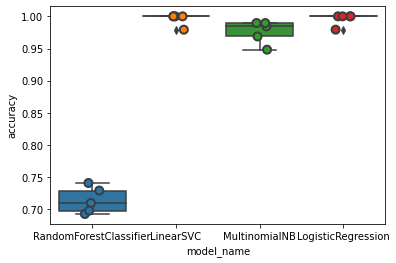

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [22]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.995855
LogisticRegression        0.995855
MultinomialNB             0.976106
RandomForestClassifier    0.714114
Name: accuracy, dtype: float64

As we can observe an SVM and the Logistic regression models seem to be doing better with accuracy of around 60-70%.



### Linear SVC:


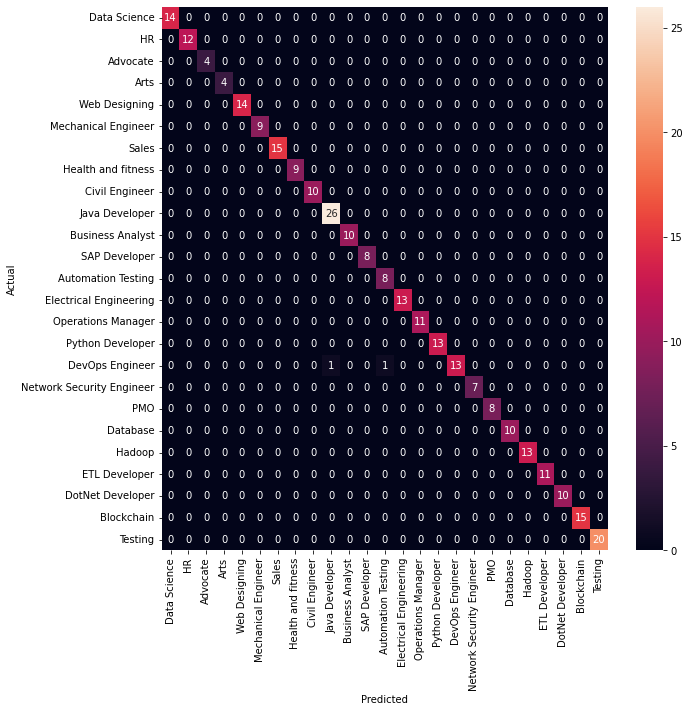

In [23]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.30, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix


conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**As we can clearly see from the visualization that a vast majority of the predicted values lie on the diagonal representing True Positive values**